In [30]:
library(tidyverse)
library(repr)
library(readxl)
library(infer)
library(cowplot)
library(GGally)
library(broom)
library(dplyr)
library(AER)
library(digest)
library(gridExtra)
library(caret)
library(pROC)
library(boot)
library(glmnet)
library(leaps)
library(faraway)
library(mltools)


Attaching package: ‘faraway’


The following objects are masked from ‘package:boot’:

    logit, melanoma


The following object is masked from ‘package:lattice’:

    melanoma


The following objects are masked from ‘package:survival’:

    rats, solder


The following objects are masked from ‘package:car’:

    logit, vif


The following object is masked from ‘package:GGally’:

    happy




In [2]:
set.seed(4)
crime_data <- read_csv("data/communities.data", col_names = FALSE)

head(crime_data)

Rows: 1994 Columns: 128
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (26): X2, X3, X4, X31, X102, X103, X104, X105, X106, X107, X108, X109, ...
dbl (102): X1, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,⋯,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,⋯,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,⋯,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,⋯,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,⋯,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
6,?,?,SouthPasadenacity,1,0.02,0.28,0.06,0.54,1.00,⋯,0.01,0.58,0.10,?,?,?,?,0.00,?,0.14


In [3]:
crime <- crime_data %>%
  select(X1,X6,X14,X17,X26,X34,X36,X38,X47,X48,X128)%>%
  rename(state = X1,
         popComm = X6,
         agePct16t24 = X14,
         pctUrban = X17,
         perCapInc = X26,
         pctUnderPov = X34,
         pctNotHSGrad = X36,
         pctUnemployed = X38,
         pctDiv = X47,
         meanPerFam = X48,
         totCrimesPerPop = X128)
crime$pctUrban <- if_else(crime$pctUrban > 0,
                 "urban","non-urban")
crime <- crime%>%
  mutate(pctUrban = as_factor(pctUrban))

head(crime)
tail(crime)
nrow(crime)

state,popComm,agePct16t24,pctUrban,perCapInc,pctUnderPov,pctNotHSGrad,pctUnemployed,pctDiv,meanPerFam,totCrimesPerPop
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8,0.19,0.29,urban,0.40,0.19,0.18,0.27,0.75,0.35,0.20
53,0.00,0.35,urban,0.37,0.24,0.24,0.27,1.00,0.29,0.67
24,0.00,0.28,non-urban,0.27,0.27,0.43,0.36,0.70,0.45,0.43
34,0.04,0.34,urban,0.36,0.10,0.25,0.33,0.44,0.75,0.12
42,0.01,0.23,urban,0.43,0.06,0.30,0.12,0.21,0.51,0.03
6,0.02,0.27,urban,0.72,0.12,0.12,0.10,0.58,0.44,0.14


state,popComm,agePct16t24,pctUrban,perCapInc,pctUnderPov,pctNotHSGrad,pctUnemployed,pctDiv,meanPerFam,totCrimesPerPop
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
28,0.02,0.43,non-urban,0.17,0.76,0.62,0.61,0.64,0.53,0.19
12,0.01,0.35,urban,0.49,0.16,0.11,0.12,0.53,0.35,0.09
6,0.05,0.73,urban,0.18,0.32,0.37,0.24,0.48,0.71,0.45
9,0.16,0.31,urban,0.31,0.31,0.58,0.50,0.52,0.47,0.23
25,0.08,0.63,urban,0.40,0.16,0.35,0.37,0.32,0.46,0.19
6,0.20,0.40,urban,0.24,0.35,0.55,0.47,0.57,0.86,0.48


[1] 1994

In [4]:
clean_crime <- crime %>%
filter(state == 6) %>%
select(- state)
head(clean_crime)

popComm,agePct16t24,pctUrban,perCapInc,pctUnderPov,pctNotHSGrad,pctUnemployed,pctDiv,meanPerFam,totCrimesPerPop
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.02,0.27,urban,0.72,0.12,0.12,0.10,0.58,0.44,0.14
0.01,0.36,non-urban,0.10,0.64,0.82,1.00,0.52,0.78,0.55
0.13,0.35,urban,0.33,0.18,0.36,0.32,0.46,0.85,0.24
0.04,0.30,urban,0.79,0.18,0.14,0.19,0.66,0.35,0.21
0.25,0.28,urban,0.29,0.34,0.43,0.59,0.67,0.60,0.34
0.02,0.39,non-urban,0.08,0.63,1.00,1.00,0.33,1.00,0.31


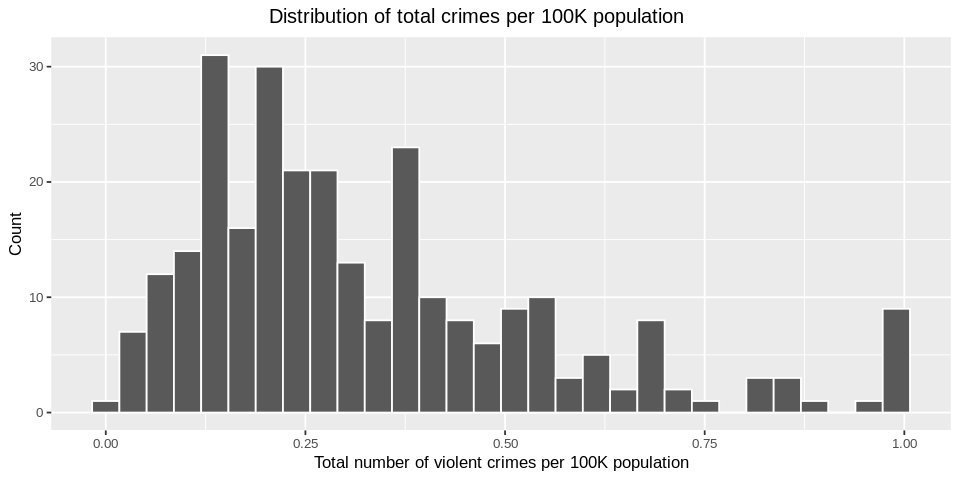

In [5]:
options(repr.plot.width = 8, repr.plot.height = 4)

tot_crime_dist <- clean_crime %>%
    ggplot(aes(x = totCrimesPerPop)) +
    geom_histogram(bins = 30, color = "white") +
    xlab("Total number of violent crimes per 100K population") +
    ylab("Count") +
    ggtitle("Distribution of total crimes per 100K population") +
    theme(text = element_text(size = 10)) +
    theme(plot.title = element_text(hjust = 0.45))
tot_crime_dist

In [6]:
# options(repr.plot.width = 11, repr.plot.height = 6)

# crime_pair_plots <- clean_crime %>%
#     ggpairs(progress = FALSE) +
#   theme(
#     text = element_text(size = 10),
#     plot.title = element_text(face = "bold"),
#     axis.title = element_text(face = "bold"),
#     axis.text.x = element_text(angle = 20, hjust = 1)
# )
# crime_pair_plots

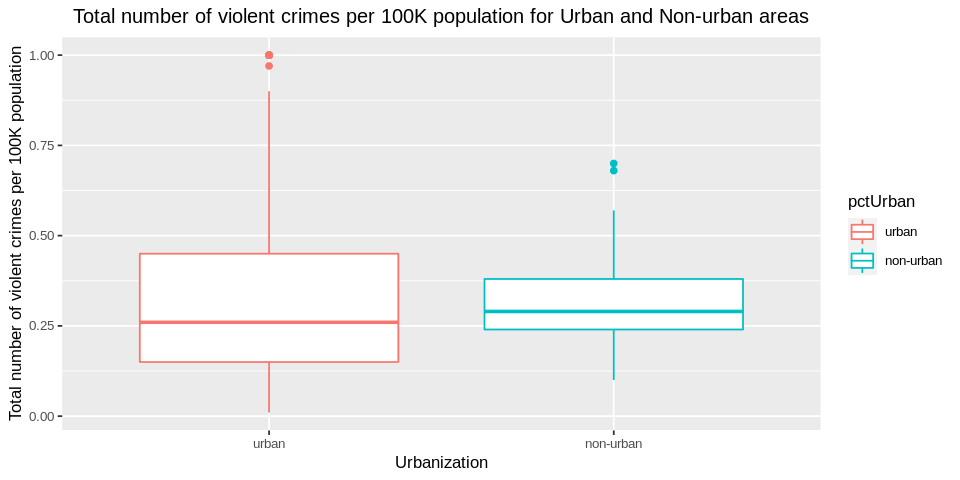

In [7]:
options(repr.plot.width = 8, repr.plot.height = 4)

urban_totCrime_boxplot <- 
    clean_crime %>%
    ggplot(aes(x = pctUrban, y = totCrimesPerPop , color = pctUrban)) +
    geom_boxplot() +
    xlab("Urbanization") +
    ylab("Total number of violent crimes per 100K population") +
    ggtitle("Total number of violent crimes per 100K population for Urban and Non-urban areas") +
    theme(text = element_text(size = 10)) +
    theme(plot.title = element_text(hjust = 0.5))

urban_totCrime_boxplot

In [8]:
crime_summary <-
    clean_crime %>%
    select(-pctUrban) %>%
    pivot_longer(cols = everything()) %>%
    group_by(name) %>% 
    summarise(
    mean = mean(value,na.rm = T),
    sd = sd(value,na.rm = T),
    median = median(value, na.rm = T),
    variance = var(value, na.rm = T),
    max = max(value, na.rm = T),
    min = min(value, na.rm = T))

crime_summary

name,mean,sd,median,variance,max,min
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
agePct16t24,0.33406475,0.1373223,0.310,0.01885743,1.00,0.09
meanPerFam,0.59312950,0.2219651,0.575,0.04926851,1.00,0.08
pctDiv,0.55500000,0.1502267,0.550,0.02256805,0.92,0.08
pctNotHSGrad,0.37967626,0.2516220,0.335,0.06331361,1.00,0.02
pctUnderPov,0.27661871,0.1807827,0.230,0.03268239,0.86,0.02
pctUnemployed,0.38611511,0.2341064,0.330,0.05480579,1.00,0.02
perCapInc,0.40586331,0.2344757,0.350,0.05497885,1.00,0.02
popComm,0.08992806,0.1442471,0.050,0.02080722,1.00,0.00
totCrimesPerPop,0.33046763,0.2261883,0.265,0.05116115,1.00,0.01


**Check Model Assumption**

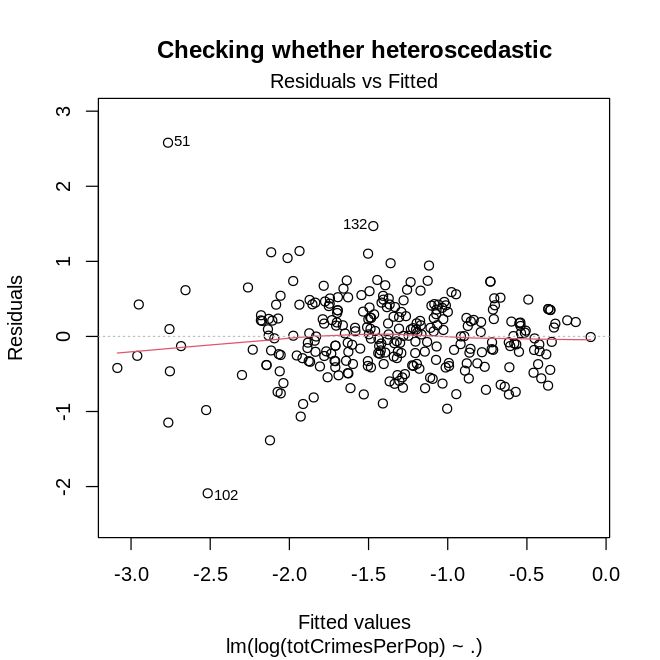

In [9]:
#check heteroscedastic
model <- lm(formula = log(totCrimesPerPop) ~., data = clean_crime)

options(repr.plot.width = 5.5, repr.plot.height = 5.5)
plot(model, 1, main = "Checking whether heteroscedastic")


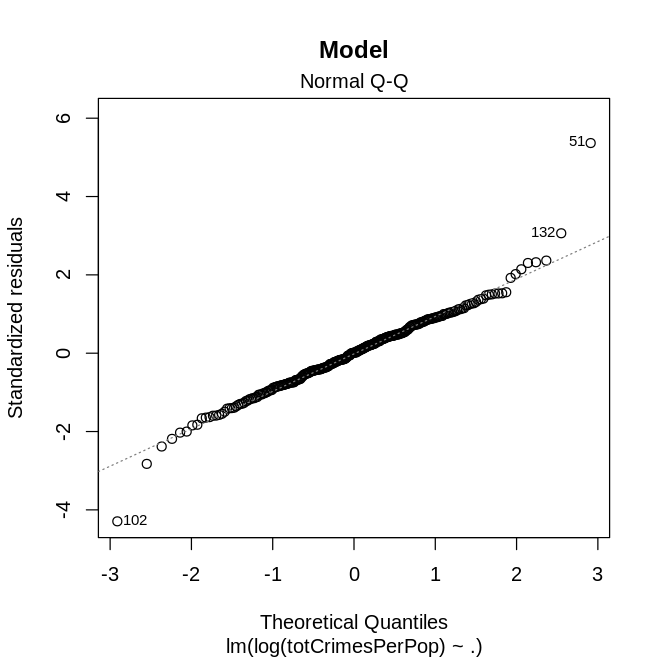

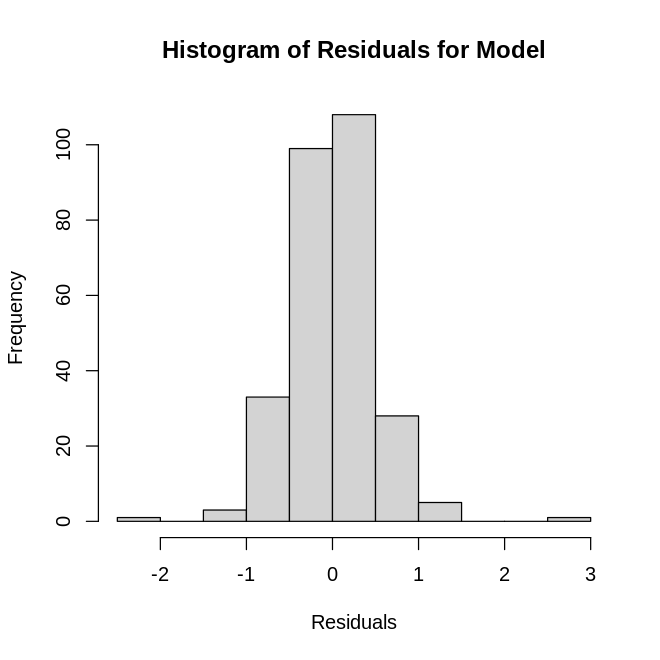

In [10]:
#check normality 
plot(model, 2, main = "Model")

hist(residuals(object = model),
  breaks = 10,
  main = "Histogram of Residuals for Model",
  xlab = "Residuals"
)

In [11]:
#check multicollinearity
corr_matrix_crime <- 
    clean_crime %>%
    select(- pctUrban) %>%
    cor() %>%
    as.data.frame() %>%
    rownames_to_column("var1") %>%
    pivot_longer(- var1, names_to = "var2", values_to = "corr")
head(corr_matrix_crime)

var1,var2,corr
<chr>,<chr>,<dbl>
popComm,popComm,1.00000000
popComm,agePct16t24,0.10125574
popComm,perCapInc,-0.06563080
popComm,pctUnderPov,0.12584493
popComm,pctNotHSGrad,0.04808012
popComm,pctUnemployed,0.03843491


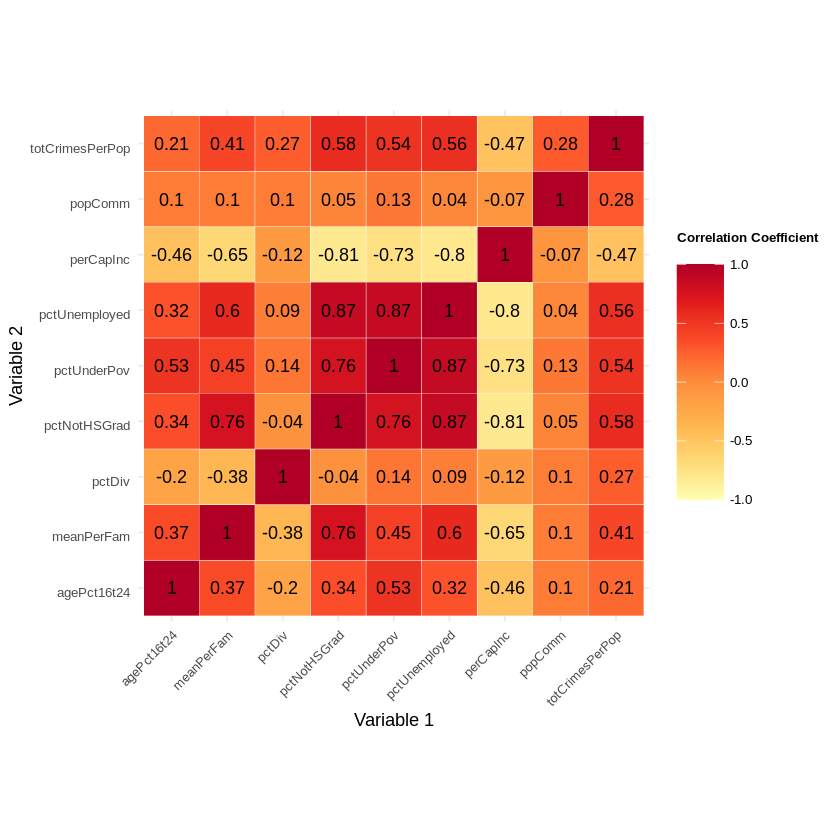

In [12]:
# plot vif
options(repr.plot.width = 7, repr.plot.height = 7)

plot_corr_matrix_crime <- corr_matrix_crime %>%
  ggplot(aes(var1, var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
    palette =  "YlOrRd",
    direction = 1, limits = c(-1,1)
  ) +
  labs(x = "Variable 1", y = "Variable 2") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 8, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 8, hjust = 1
    ),
    legend.title = element_text(size = 8, face = "bold"),
    legend.text = element_text(size = 8),
    legend.key.size = unit(1, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 3.8)
plot_corr_matrix_crime

In [13]:
# get vif of variables
VIF_crime <- vif(model)
round(VIF_crime, 3)

popComm   agePct16t24      pctUrban     perCapInc   pctUnderPov 
        1.143         2.324         1.501         4.794         7.432 
 pctNotHSGrad pctUnemployed        pctDiv    meanPerFam 
        7.448         9.316         1.970         4.622

In [14]:
# Divide data into training set and testing set
clean_crime$ID <- 1:nrow(clean_crime)
crime_train <- 
    slice_sample(clean_crime, prop = 0.70) 
    
crime_test <- 
    clean_crime %>%
    anti_join(crime_train, by = "ID")

head(crime_train)
nrow(crime_train)
head(crime_test)
nrow(crime_test)

popComm,agePct16t24,pctUrban,perCapInc,pctUnderPov,pctNotHSGrad,pctUnemployed,pctDiv,meanPerFam,totCrimesPerPop,ID
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0.07,0.31,urban,0.56,0.08,0.14,0.17,0.35,0.72,0.19,75
0.20,0.43,urban,0.19,0.49,0.71,0.60,0.51,1.00,0.67,259
0.04,0.45,urban,0.45,0.16,0.17,0.07,0.62,0.31,0.36,71
0.02,0.25,urban,0.77,0.08,0.09,0.18,0.40,0.66,0.15,172
0.02,0.23,non-urban,0.33,0.20,0.22,0.21,0.61,0.49,0.14,245
0.55,0.37,urban,0.22,0.64,0.54,0.56,0.67,0.70,0.59,186


[1] 194

popComm,agePct16t24,pctUrban,perCapInc,pctUnderPov,pctNotHSGrad,pctUnemployed,pctDiv,meanPerFam,totCrimesPerPop,ID
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0.13,0.35,urban,0.33,0.18,0.36,0.32,0.46,0.85,0.24,3
0.02,0.39,non-urban,0.08,0.63,1.00,1.00,0.33,1.00,0.31,6
0.06,0.32,urban,0.32,0.25,0.46,0.35,0.62,0.58,0.84,7
0.03,0.26,urban,0.80,0.06,0.05,0.16,0.54,0.41,0.08,8
0.05,0.24,non-urban,0.41,0.10,0.22,0.20,0.59,0.49,0.21,15
0.02,0.13,urban,0.71,0.11,0.22,0.12,0.50,0.14,0.10,16


[1] 84

In [15]:
crime_train <- crime_train %>% select(- "ID")
crime_test <- crime_test %>% select(- "ID")

In [16]:
# forward selection for inference and predictive
crime_forward_sel <- regsubsets(
    x = totCrimesPerPop ~., nvmax = 9,
    data = crime_train,
    method = "forward")

crime_forward_summary <- summary(crime_forward_sel)
crime_forward_summary

Subset selection object
Call: regsubsets.formula(x = totCrimesPerPop ~ ., nvmax = 9, data = crime_train, 
    method = "forward")
9 Variables  (and intercept)
                  Forced in Forced out
popComm               FALSE      FALSE
agePct16t24           FALSE      FALSE
pctUrbannon-urban     FALSE      FALSE
perCapInc             FALSE      FALSE
pctUnderPov           FALSE      FALSE
pctNotHSGrad          FALSE      FALSE
pctUnemployed         FALSE      FALSE
pctDiv                FALSE      FALSE
meanPerFam            FALSE      FALSE
1 subsets of each size up to 9
Selection Algorithm: forward
         popComm agePct16t24 pctUrbannon-urban perCapInc pctUnderPov
1  ( 1 ) " "     " "         " "               " "       "*"        
2  ( 1 ) "*"     " "         " "               " "       "*"        
3  ( 1 ) "*"     " "         " "               " "       "*"        
4  ( 1 ) "*"     " "         " "               " "       "*"        
5  ( 1 ) "*"     " "         "*"              

In [17]:
crime_forward_summary_df <- tibble(
    n_input_variables = 1:9,
    RSQ = crime_forward_summary$rsq,
    RSS = crime_forward_summary$rss,
    ADJ.R2 = crime_forward_summary$adjr2,
    Cp = crime_forward_summary$cp,
    BIC = crime_forward_summary$bic,
)
crime_forward_summary_df
#for inference we look at ADJ.R2(higher is better); for predictive, we look at Cp(lower is better)

n_input_variables,RSQ,RSS,ADJ.R2,Cp,BIC
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.3359235,6.777827,0.3324648,81.867223,-68.87973
2,0.3909399,6.216308,0.3845623,61.343976,-80.38907
3,0.4362359,5.753999,0.4273344,44.800186,-90.11374
4,0.4766454,5.341564,0.4655691,30.256901,-99.27493
5,0.5013032,5.089897,0.4880400,22.162200,-103.36971
6,0.5174568,4.925027,0.5019742,17.549043,-104.48986
7,0.5364810,4.730858,0.5190368,11.760695,-107.02528
8,0.5499817,4.593065,0.5305215,8.233629,-107.49189
9,0.5505524,4.587240,0.5285686,10.000000,-102.47020


In [18]:
# for inference model, we want to compare a full model and a reduced model

#full model
crime_full_OLS_inf <- lm(formula = totCrimesPerPop ~., data = crime_train)
tidy(crime_full_OLS_inf)

#reduced model
crime_reduced_OLS_inf <- lm(formula = totCrimesPerPop ~ popComm + pctUrban + perCapInc + pctUnderPov + pctNotHSGrad 
                            + pctUnemployed + pctDiv + meanPerFam, data = crime_train)
tidy(crime_reduced_OLS_inf)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-0.57652272,0.14810577,-3.8926418,1.385503e-04
popComm,0.34487668,0.08388796,4.1111581,5.925588e-05
agePct16t24,0.06022987,0.12460876,0.4833518,6.294206e-01
pctUrbannon-urban,-0.12090024,0.04161261,-2.9053753,4.118100e-03
perCapInc,0.35829893,0.10501695,3.4118202,7.933779e-04
pctUnderPov,0.04358649,0.17211048,0.2532471,8.003600e-01
pctNotHSGrad,0.31247892,0.12480154,2.5038065,1.315657e-02
pctUnemployed,0.43274570,0.15213514,2.8444823,4.952172e-03
pctDiv,0.52903760,0.10639165,4.9725480,1.507930e-06


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-0.54459702,0.13228695,-4.1167857,5.782603e-05
popComm,0.34334054,0.08365393,4.1042966,6.076304e-05
pctUrbannon-urban,-0.12419854,0.04096418,-3.0318811,2.779093e-03
perCapInc,0.34093722,0.09847849,3.4620476,6.658180e-04
pctUnderPov,0.07931676,0.15510480,0.5113753,6.096981e-01
pctNotHSGrad,0.30450872,0.12345091,2.4666380,1.454897e-02
pctUnemployed,0.41296689,0.14622483,2.8241913,5.259722e-03
pctDiv,0.51617474,0.10279611,5.0213451,1.201824e-06
meanPerFam,0.24626385,0.10453265,2.3558559,1.952681e-02


In [19]:
glance(crime_full_OLS_inf)$r.squared
glance(crime_reduced_OLS_inf)$r.squared

[1] 0.5505524

[1] 0.5499817

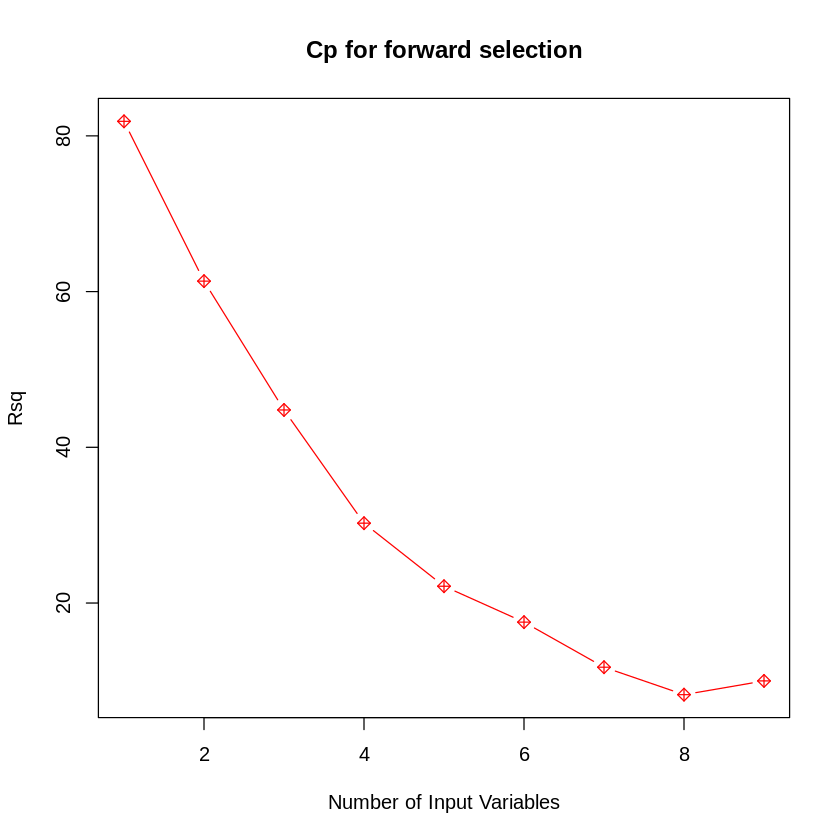

In [20]:
# choose cp
plot(summary(crime_forward_sel)$cp,
  main = "Cp for forward selection",
  xlab = "Number of Input Variables", ylab = "Rsq", type = "b", pch = 9,
  col = "red"
)

In [21]:
# for predictive model, we also compare a full model and a reduced model

#full model
crime_full_OLS_pred <- lm(formula = totCrimesPerPop ~., data = crime_train)
test_crime_full_OLS_pred <- predict(crime_full_OLS_pred, newdata = crime_test)
crime_R_MSE_pred_models <- tibble(
    Model = "OLS Full Regression",
    R_MSE = rmse(
        preds = test_crime_full_OLS_pred,
        actuals = crime_test$totCrimesPerPop))
crime_R_MSE_pred_models


Model,R_MSE
<chr>,<dbl>
OLS Full Regression,0.1694721


In [22]:
# reduced model
crime_reduced_OLS_pred <- lm(formula = totCrimesPerPop ~ popComm + pctUrban + perCapInc + pctUnderPov + pctNotHSGrad 
                            + pctUnemployed + pctDiv + meanPerFam, data = crime_train)
test_crime_reduced_OLS_pred <- predict(crime_reduced_OLS_pred, newdata = crime_test)
crime_R_MSE_pred_models <- rbind(
    crime_R_MSE_pred_models,
    tibble(
        Model = "OLS Reduced Regression",
        R_MSE = rmse(
            preds = test_crime_reduced_OLS_pred,
            actuals = crime_test$totCrimesPerPop)))
crime_R_MSE_pred_models

Model,R_MSE
<chr>,<dbl>
OLS Full Regression,0.1694721
OLS Reduced Regression,0.1701148


## Lasso

In [24]:
# build matrix 
crime_train_X <- crime_train %>% select(- "totCrimesPerPop") %>% as.matrix()
crime_train_Y <- crime_train %>% select("totCrimesPerPop") %>% as.matrix()

crime_test_X <- crime_test %>% select(- "totCrimesPerPop") %>% as.matrix()
crime_test_Y <- crime_test %>% select("totCrimesPerPop") %>% as.matrix()


In [31]:
# choose lambda
crime_cv_lambda_LASSO <- cv.glmnet(
    x = crime_train_X, 
    y = crime_train_Y,
    alpha = 1)

plot(crime_cv_lambda_LASSO, main = "Lambda selection by CV with LASSO\n\n")

Warning message in storage.mode(xd) <- "double":
“NAs introduced by coercion”


ERROR: Error in elnet(xd, is.sparse, ix, jx, y, weights, offset, type.gaussian, : NA/NaN/Inf in foreign function call (arg 5)
